In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('seaborn-whitegrid') # For plots
import datetime

from sklearn.preprocessing import MinMaxScaler

Importing plotly failed. Interactive plots will not work.


# Prepare data

In [2]:
def format_data(df):
    
    # index is date
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)
    
    # add missing date
    idx = pd.date_range(start = min(df.index), end = max(df.index))
    df = df.reindex(idx)
    
    # fill na with the previous value
    df = df.fillna(1) # 0 might makes more sense
    
    # replace estimated_fire_area with log
    df = df.rename(columns = {"Estimated_fire_area": "fire"})
    df["fire_log"] = np.log(df["fire"])
    
    # remove difference
    df["fire_diff"] = (df["fire"] - df["fire"].shift()).fillna(0)
    
    # create feature
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    return df

In [3]:
nsw = pd.read_csv("../data/regions/NSW.csv")
nsw = format_data(nsw)
nsw.head()

<ipython-input-2-2ba4bf4088cd>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


,Precipitation_max,RelativeHumidity_max,SoilWaterContent_max,SolarRadiation_max,Temperature_max,WindSpeed_max,Precipitation_mean,RelativeHumidity_mean,SoilWaterContent_mean,SolarRadiation_mean,...,fire_log,fire_diff,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2005-01-04,22.842566,90.332771,0.444927,33.214062,28.945488,7.364222,2.808620,57.095628,0.214293,22.617291,...,2.161022,0.00000,2005-01-04,1,1,1,2005,4,4,1
2005-01-05,7.657155,88.623436,0.442955,33.554867,29.510120,7.091141,0.157935,47.170735,0.203951,28.076835,...,2.810080,7.93125,2005-01-05,2,1,1,2005,5,5,1
2005-01-06,27.616505,92.850960,0.431879,34.075787,26.982698,9.905821,0.434833,39.874638,0.193668,30.561703,...,1.708378,-11.09125,2005-01-06,3,1,1,2005,6,6,1
2005-01-07,3.839235,79.103134,0.418513,34.019218,24.752069,10.446799,0.064224,39.279410,0.183778,32.143718,...,1.834819,0.74400,2005-01-07,4,1,1,2005,7,7,1
2005-01-08,2.866673,83.001541,0.413370,33.265091,26.472469,6.671862,0.203352,42.400824,0.175935,29.347715,...,1.686399,-0.86400,2005-01-08,5,1,1,2005,8,8,1


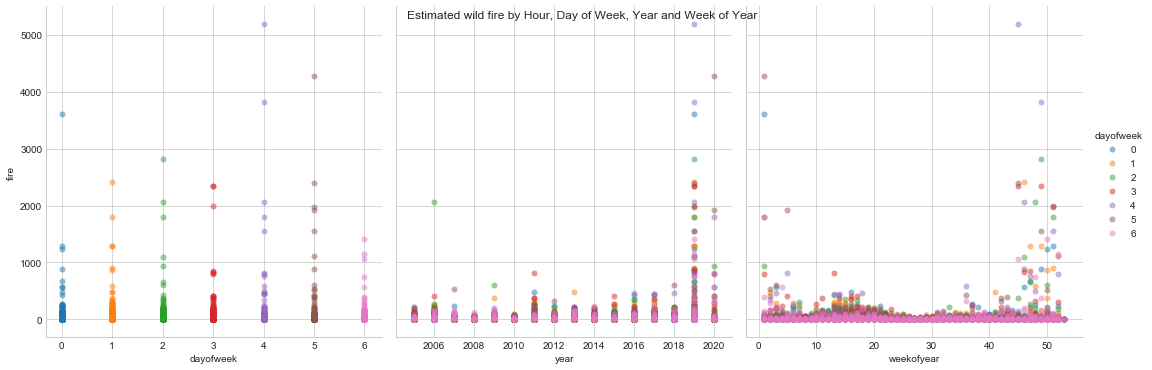

In [4]:
sns.pairplot(nsw.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='fire',
             height=5,
             plot_kws={'alpha':0.5, 'linewidth':0}
            )
plt.suptitle('Estimated wild fire by Hour, Day of Week, Year and Week of Year')
plt.show()

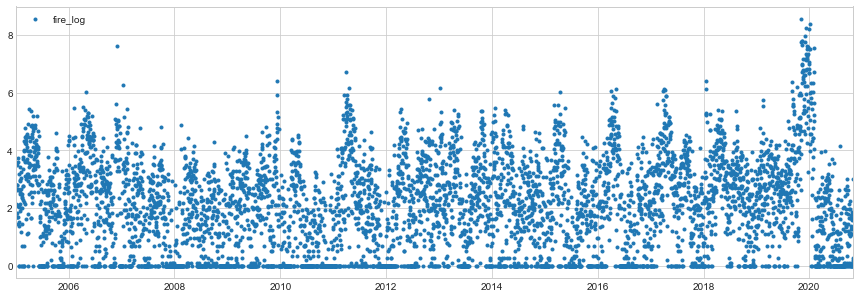

In [5]:
nsw[nsw.index <= '2022-1-1'].plot(y = "fire_log", figsize = (15, 5), style = ".")
plt.show()

In [6]:
ts = nsw[["fire_log"]]
ts = ts.reset_index().rename(columns = {"index": "ds", "fire_log": "y"})
ts

,ds,y
0,2005-01-04,2.161022
1,2005-01-05,2.810080
2,2005-01-06,1.708378
3,2005-01-07,1.834819
4,2005-01-08,1.686399
...,...,...
5775,2020-10-27,0.190620
5776,2020-10-28,1.098612
5777,2020-10-29,0.000000
5778,2020-10-30,0.277632


In [50]:
split_date = "2018-01-01"
end_date = "2019-09-01"
ts_train = ts.loc[ts["ds"] < split_date].copy()
ts_test = ts.loc[(split_date <= ts["ds"]) & (ts["ds"] < end_date)].copy()

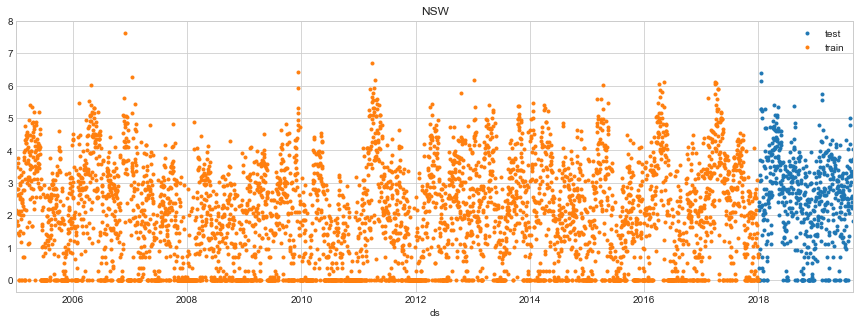

In [51]:
ts_test.set_index("ds") \
    .rename(columns={'y': 'test'}) \
    .join(ts_train.set_index("ds").rename(columns={'y': 'train'}), how='outer') \
    .plot(figsize=(15,5), title='NSW', style='.')
plt.show()

# Prophet

In [52]:
m = Prophet()
m.fit(ts_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
forcast = m.predict(ts_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


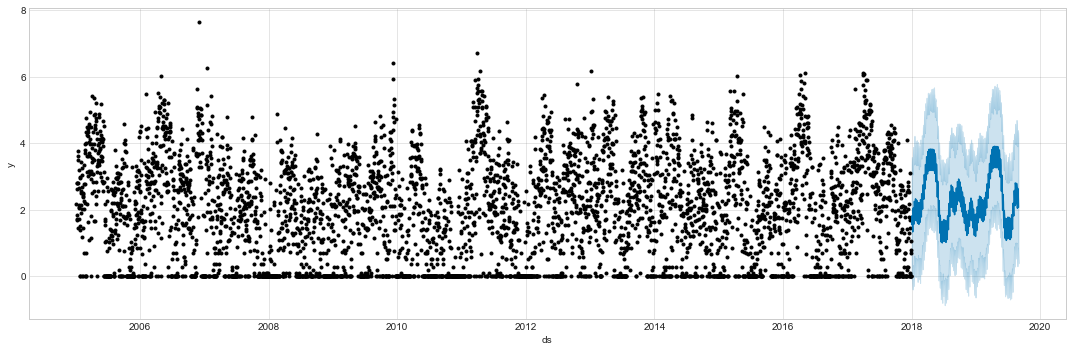

In [54]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(forcast, ax=ax)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3

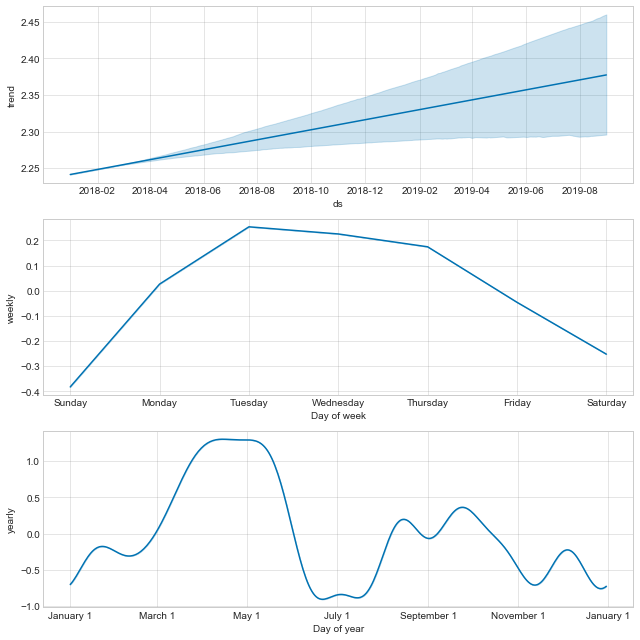

In [55]:
fig = m.plot_components(forcast)

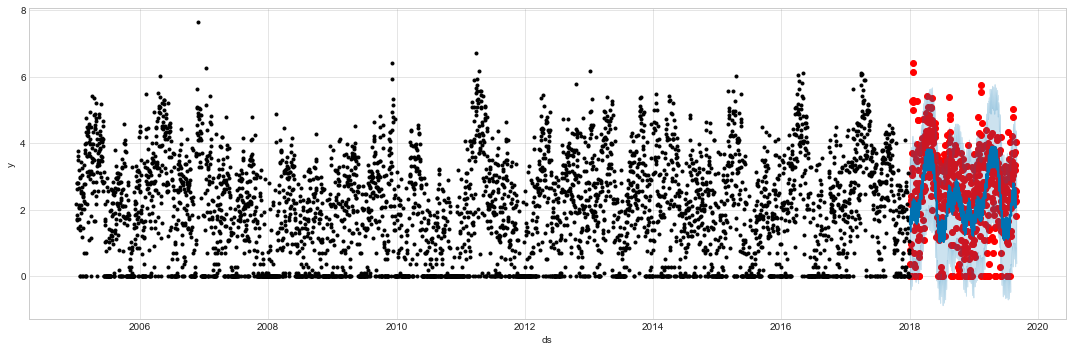

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test["ds"], ts_test['y'], color='r')
fig = m.plot(forcast, ax=ax)

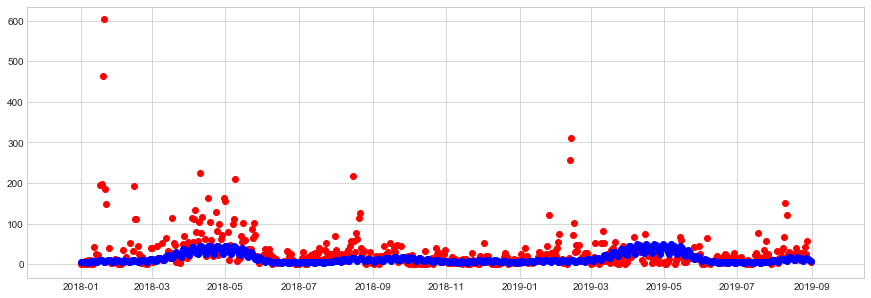

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test["ds"], np.exp(ts_test['y']), color='r')
ax.scatter(forcast['ds'], np.exp(forcast['yhat']), color = 'b')
# fig = m.plot(forcast, ax=ax)

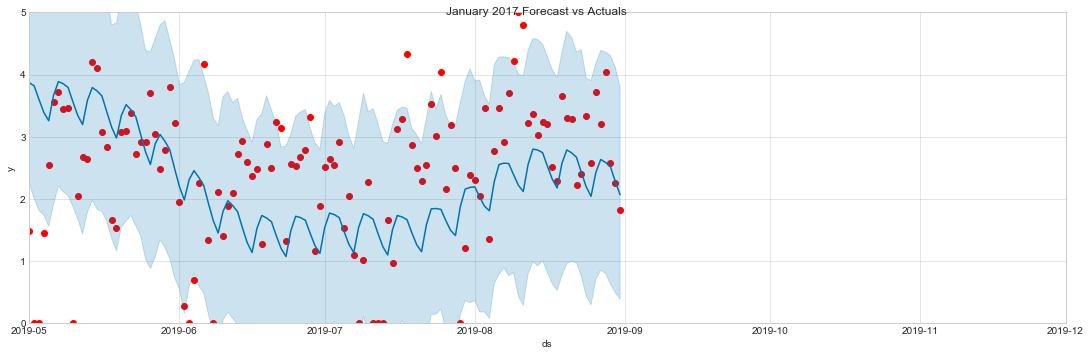

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pd.to_datetime(ts_test["ds"]), ts_test['y'], color='r')
fig = m.plot(forcast, ax=ax)
ax.set_xbound(lower=datetime.datetime(2019,5,1),
              upper=datetime.datetime(2019,12,1))
ax.set_ylim(0, 5)
plot = plt.suptitle('January 2017 Forecast vs Actuals')

In [60]:
mse = mean_squared_error(y_true = np.exp(ts_test["y"]), y_pred = np.exp(forcast["yhat"]))
mae = mean_absolute_error(y_true = np.exp(ts_test["y"]), y_pred = np.exp(forcast["yhat"]))
rmse = np.sqrt(mse)

rmse, mae

(47.634561550349524, 20.58351636783314)

In [61]:
forcast_train = m.predict(ts_train)

In [62]:
mse = mean_squared_error(y_true = np.exp(ts_train["y"]), y_pred = np.exp(forcast_train["yhat"]))
mae = mean_absolute_error(y_true = np.exp(ts_train["y"]), y_pred = np.exp(forcast_train["yhat"]))
rmse = np.sqrt(mse)

rmse, mae

(53.79042646061766, 18.680668845555985)

In [63]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

mape = mean_absolute_percentage_error(y_true = np.exp(ts_test["y"]), y_pred = np.exp(forcast["yhat"]))
mape

165.00260892882622

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


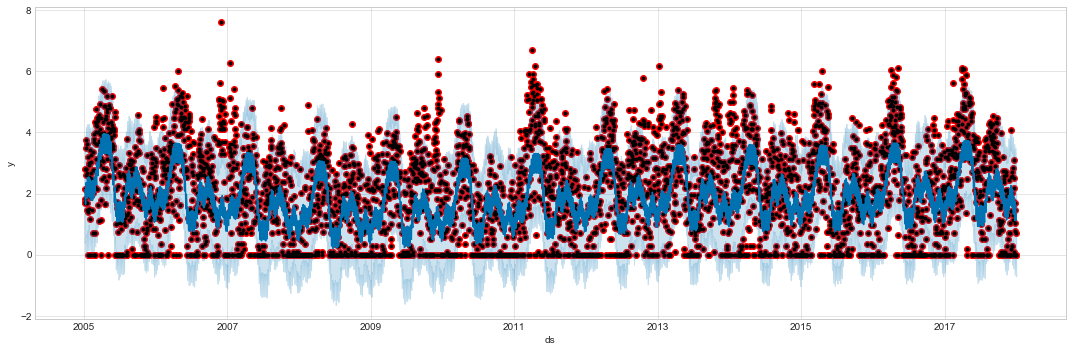

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_train["ds"], ts_train['y'], color='r')
fig = m.plot(forcast_train, ax=ax)

In [21]:
ts_future = m.make_future_dataframe(periods = 1750)
ts_future.tail()

,ds
6490,2022-10-12
6491,2022-10-13
6492,2022-10-14
6493,2022-10-15
6494,2022-10-16


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


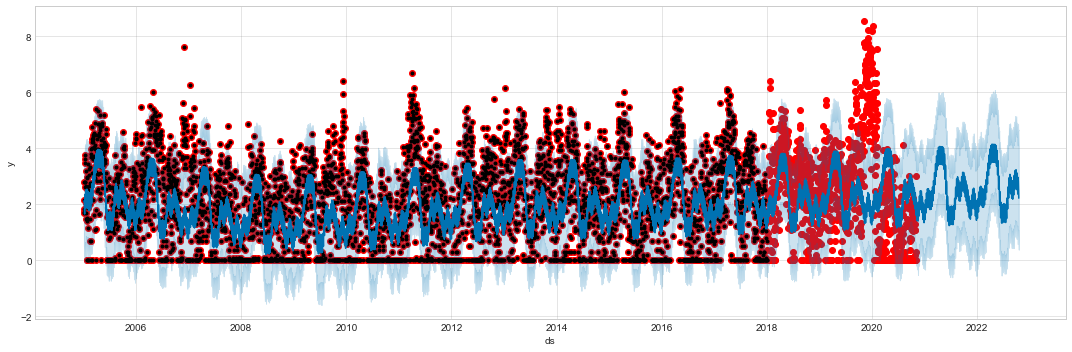

In [22]:
future = m.predict(ts_future)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts["ds"], ts['y'], color='r')
fig = m.plot(future, ax=ax)

# SARIMAX


In [23]:
fire = pd.read_csv("../data/Historical_Wildfire_fill0.csv")
fire = fire.rename(columns = {'Date': 'date', 'Estimated_fire_area': 'fire', 'Region': 'region'})
fire['date'] = pd.to_datetime(fire['date'])
fire = fire.drop(['Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power', 'Mean_confidence'], axis = 1)
fire = fire.set_index('date')

In [24]:
nsw = fire[fire['region'] == 'NSW'].drop('region', axis = 1)

# log scale
nsw['fire'] = nsw['fire'].replace(0, 1) # na is 1 instead of 0 for log
nsw['fire_log'] = np.log(nsw['fire'])

# consider only < 2019-07-01
nsw = nsw.loc[nsw.index < "2019-07-01"]

nsw.tail()

,fire,fire_log
date,,
2019-06-26,14.533846,2.676480
2019-06-27,16.265833,2.789067
2019-06-28,27.375000,3.309630
2019-06-29,3.200000,1.163151
2019-06-30,6.630000,1.891605


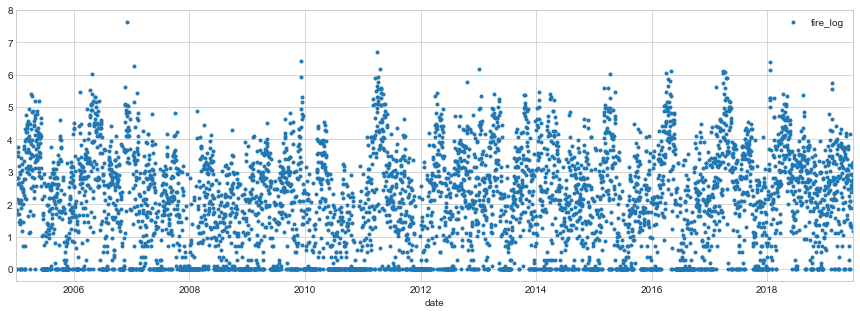

In [25]:
nsw.plot(y = 'fire_log', style = '.', figsize = (15, 5))

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook

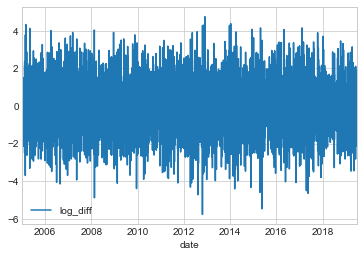

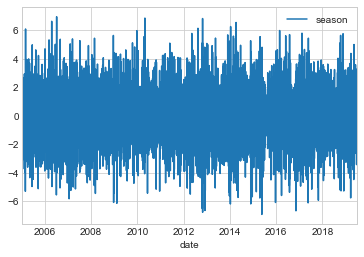

In [27]:
data = nsw.copy()

data['log_diff'] = data['fire_log'].diff()
data = data.drop(data.index[0])
data.plot(y = 'log_diff')
plt.show()

data['season'] = data['log_diff'].diff(4)
prev = data[:4]
data = data.drop(data.index[0:4], axis = 0)
data.plot(y = 'season')
plt.show()

In [28]:
ad_fuller_result = adfuller(data['season'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -25.805329587758884
p-value: 0.0


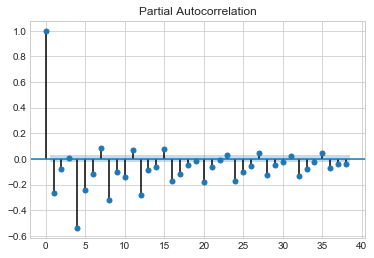

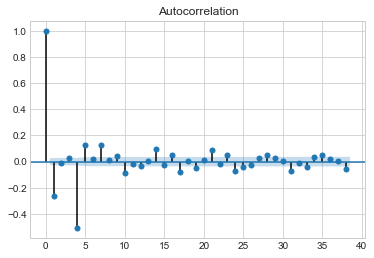

In [29]:
plot_pacf(data['season'])
plot_acf(data['season'])
plt.show()

In [30]:
# source: https://github.com/marcopeix/time-series-analysis/blob/master/Advanced%20modelling/SARIMA.ipynb
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1, maxiter = 69)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [31]:
from itertools import product

# p = range(0, 2, 1)
# d = 1
# q = range(0, 2, 1)
# P = range(0, 2, 1)
# D = 1
# Q = range(0, 2, 1)
# s = 4

# parameters = product(p, q, P, Q)
# parameters_list = list(parameters)
# print(len(parameters_list))

In [32]:
# result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['season'])
# result_df

In [33]:
# p = range(2, 4, 1)
# d = 1
# q = range(2, 4, 1)
# P = range(2, 4, 1)
# D = 1
# Q = range(2, 4, 1)
# s = 4

# parameters = product(p, q, P, Q)
# parameters_list = list(parameters)
# print(len(parameters_list))

# result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['season'])
# result_df

In [34]:
split_date = "2018-01-01"
train = data[data.index < split_date]
test = data[data.index >= split_date]

best_model = SARIMAX(train['season'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit(dis=-1)
print(best_model.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                            season   No. Observations:                 4743
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -8930.295
Date:                           Sun, 10 Jan 2021   AIC                          17870.589
Time:                                   16:25:41   BIC                          17902.906
Sample:                               01-06-2005   HQIC                         17881.947
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3447      0.014    -24.252      0.000      -0.373      -0.317
ma.L1         -0.9990      0.023    -43.910

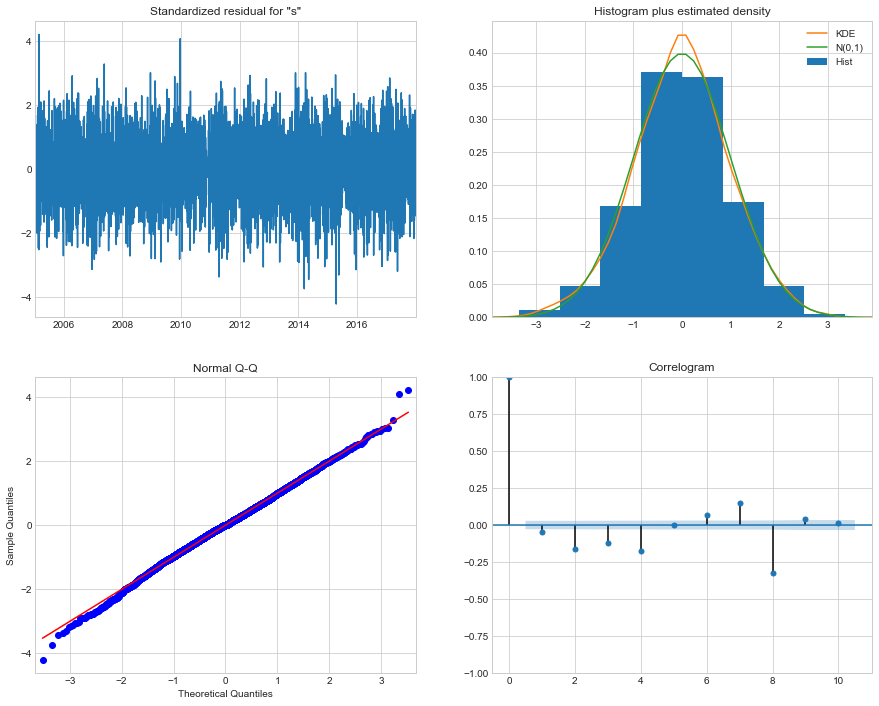

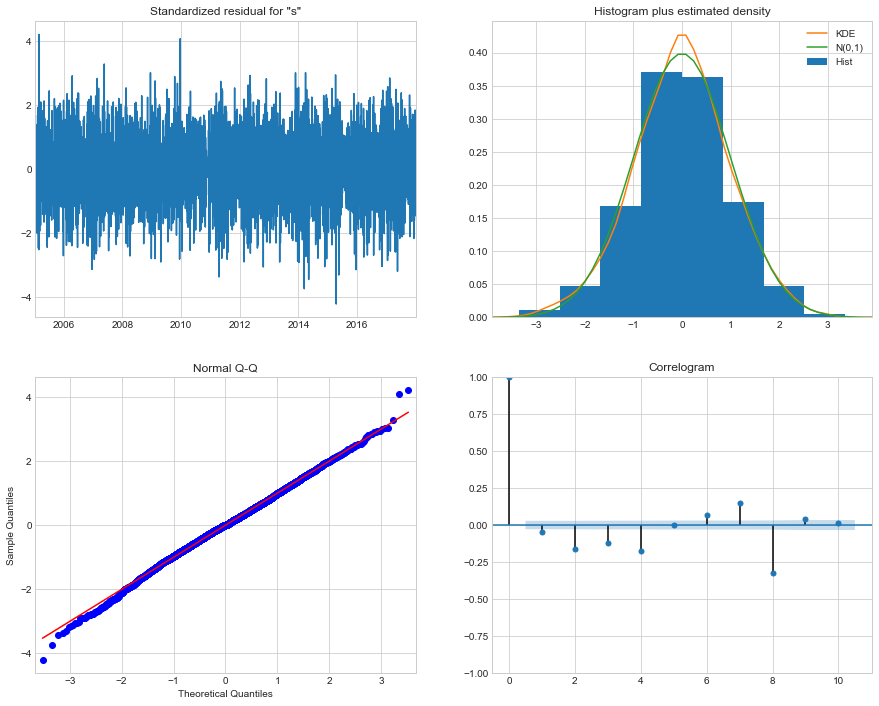

In [35]:
best_model.plot_diagnostics(figsize=(15,12))

In [36]:
data.shape[0]

5289

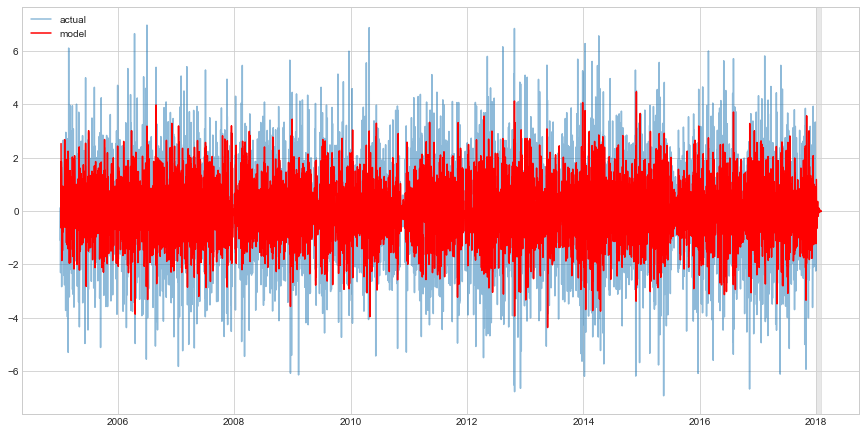

In [37]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=train.shape[0], end=train.shape[0] + 30)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(train['season'], label='actual', alpha = 0.5)
plt.plot(forecast, color='r', label='model')
plt.axvspan(train.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.legend()

plt.show()

In [38]:
pd.DataFrame(forecast)

,0
2005-01-06,NaN
2005-01-07,NaN
2005-01-08,NaN
2005-01-09,NaN
2005-01-10,NaN
...,...
2018-01-27,0.000228
2018-01-28,-0.004446
2018-01-29,-0.017868
2018-01-30,0.005025


In [39]:
data['pred_log'] = data[['season']].cumsum() + prev.iloc[3, 1]
data['pred'] = np.exp(data['pred_log'])

In [40]:
data

,fire,fire_log,log_diff,season,arima_model,pred_log,pred
date,,,,,,,
2005-01-06,5.520000,1.708378,-1.101702,-1.101702,NaN,1.708378,5.520000
2005-01-07,6.264000,1.834819,0.126441,0.126441,NaN,1.834819,6.264000
2005-01-08,5.400000,1.686399,-0.148420,-2.309442,NaN,-0.474623,0.622120
2005-01-09,13.721429,2.618959,0.932560,0.283501,NaN,-0.191121,0.826032
2005-01-10,16.625455,2.810935,0.191976,1.293679,NaN,1.102557,3.011858
...,...,...,...,...,...,...,...
2019-06-26,14.533846,2.676480,0.147557,0.249190,NaN,-0.462741,0.629556
2019-06-27,16.265833,2.789067,0.112587,1.930052,NaN,1.467311,4.337556
2019-06-28,27.375000,3.309630,0.520563,-0.720390,NaN,0.746921,2.110492


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


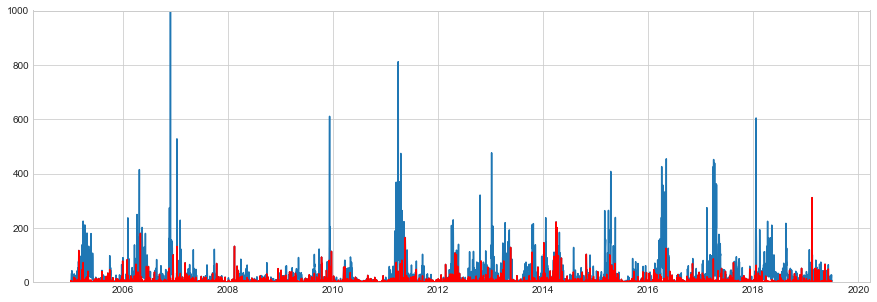

In [41]:
plt.figure(figsize = (15, 5))
plt.gca().set_ylim([0, 1000])
plt.plot(data.index, data['fire'], label = 'actual')
plt.plot(data.index, data['pred'], label = 'predict', color = 'r')
plt.show()

In [42]:
res = data[['fire', 'pred']]
res

,fire,pred
date,,
2005-01-06,5.520000,5.520000
2005-01-07,6.264000,6.264000
2005-01-08,5.400000,0.622120
2005-01-09,13.721429,0.826032
2005-01-10,16.625455,3.011858
...,...,...
2019-06-26,14.533846,0.629556
2019-06-27,16.265833,4.337556
2019-06-28,27.375000,2.110492


In [43]:
np.sqrt(mean_squared_error(data['fire'], data['pred']))

54.7849893300204

In [44]:
weather = pd.read_csv("../data/HistoricalWeather.csv")
forecast = pd.read_csv("../data/HistoricalWeatherForecasts.csv")

forecast.head()

,Date,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
0,2014-01-01,NSW,RelativeHumidity,5,8.037682e+05,7.482927,85.021118,28.223569,353.620815
1,2014-01-01,NSW,SolarRadiation,5,8.037682e+05,24.865765,33.557598,31.647308,2.276068
2,2014-01-01,NSW,Temperature,5,8.037682e+05,21.243755,36.929035,30.893523,17.918553
3,2014-01-01,NSW,WindSpeed,5,8.037682e+05,1.593531,6.989559,3.958822,1.334834
4,2014-01-01,NT,RelativeHumidity,5,1.349817e+06,14.796251,73.601479,39.799856,189.805002


In [45]:
def format_weather(ori, region = 'NSW', actual = True):
    df = ori.copy()
    df = df.loc[df['Region'] == region].drop('Region', axis = 1)
    df = df.pivot_table(columns = 'Parameter',
                        values = ['min()', 'max()', 'mean()', 'variance()'],
                        index = ['Date'])
    df.reset_index(inplace=True)

    features = [col[0] if not(col[1]) else '{}_{}'.format(col[1], col[0]) for col in df.columns.values]
    df.columns = [col[0] if not(col[1]) else '{}_{}_{}'.format(col[1], col[0], actual) for col in df.columns.values]

    params = df.columns.tolist()[3:]
    params.sort()
    data = df[df.columns.tolist()[:3] + params].copy()
    data.head()
    
    return data, features

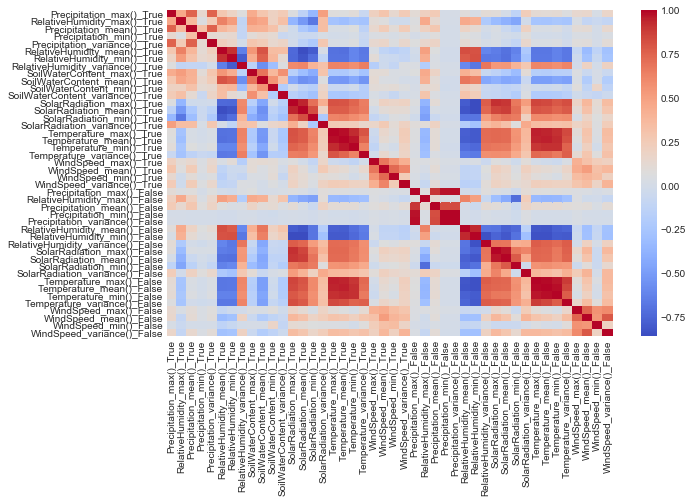

region: NSW
                                    rmse        min           max
Precipitation_max()            64.245018   0.000000   2744.413085
RelativeHumidity_max()          5.585787  68.266335     99.910851
SolarRadiation_max()            3.772563   8.535188     44.063999
Temperature_max()               2.347633  12.117125     41.738968
WindSpeed_max()                 1.929036   3.039088     14.426489
Precipitation_mean()            3.232518   0.000000    105.705134
RelativeHumidity_mean()         8.546310  22.725358     92.258786
SolarRadiation_mean()           3.895264   2.854909     40.660811
Temperature_mean()              2.228990   5.172887     34.639079
WindSpeed_mean()                0.949360   1.663665      7.352849
Precipitation_min()             1.895450   0.000000     83.429474
RelativeHumidity_min()          8.773339   5.569207     82.840332
SolarRadiation_min()            4.706356   0.542254     30.168118
Temperature_min()               2.425863  -3.745257     23.03714

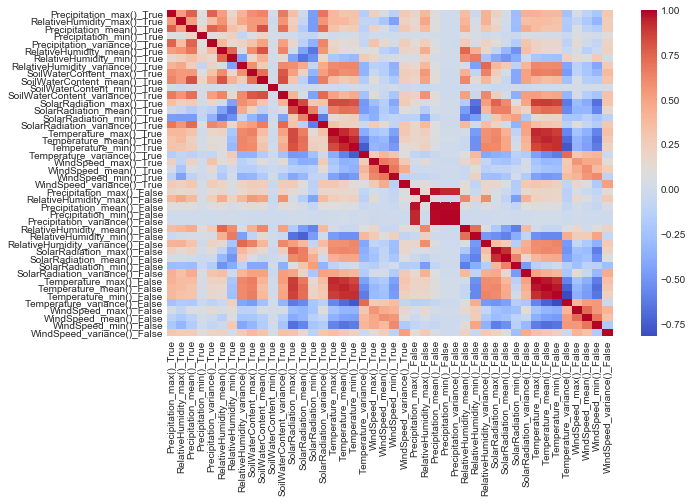

region: NT
                                     rmse        min           max
Precipitation_max()             82.632517   0.000000  3.352636e+03
RelativeHumidity_max()           6.528858  63.054150  9.798561e+01
SolarRadiation_max()             4.221776  16.690475  4.309433e+01
Temperature_max()                1.583884  23.799870  4.131904e+01
WindSpeed_max()                  1.831603   3.940639  1.666609e+01
Precipitation_mean()            12.827667   0.000000  5.578701e+02
RelativeHumidity_mean()          8.602537  15.951412  8.406187e+01
SolarRadiation_mean()            4.081805   8.089382  3.888970e+01
Temperature_mean()               1.909888  12.356656  3.640631e+01
WindSpeed_mean()                 1.152007   1.941494  7.711400e+00
Precipitation_min()              1.915250   0.000000  8.431342e+01
RelativeHumidity_min()           5.748158   3.891805  6.417046e+01
SolarRadiation_min()             5.506895   0.851255  3.347897e+01
Temperature_min()                2.567987   5.29187

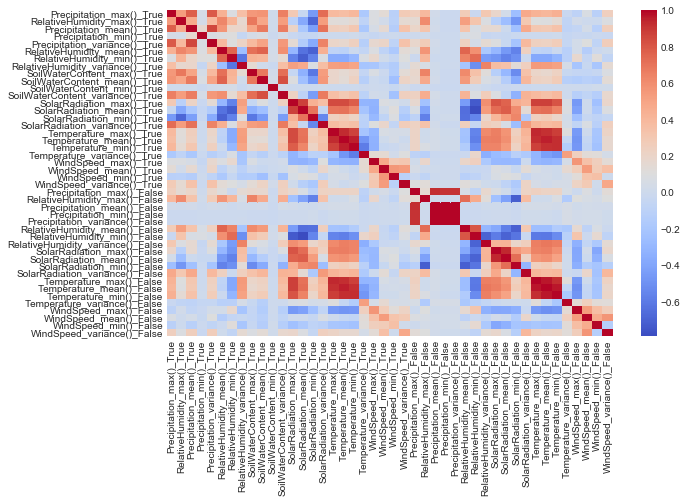

region: QL
                                      rmse           min           max
Precipitation_max()              82.735606  4.320221e-03  3.340180e+03
RelativeHumidity_max()            4.157900  6.576822e+01  9.966205e+01
SolarRadiation_max()              4.105334  1.643690e+01  4.384800e+01
Temperature_max()                 1.611631  2.402360e+01  4.237612e+01
WindSpeed_max()                   1.598474  5.047780e+00  1.961946e+01
Precipitation_mean()             38.502623  9.773833e-06  1.693325e+03
RelativeHumidity_mean()           7.109028  2.184642e+01  8.299049e+01
SolarRadiation_mean()             3.997759  6.789350e+00  3.735313e+01
Temperature_mean()                1.718346  1.157036e+01  3.371627e+01
WindSpeed_mean()                  1.027392  1.972850e+00  6.392750e+00
Precipitation_min()               1.923991  0.000000e+00  8.469897e+01
RelativeHumidity_min()            6.045034  4.363812e+00  6.242400e+01
SolarRadiation_min()              4.742851  4.732897e-01  2.726498

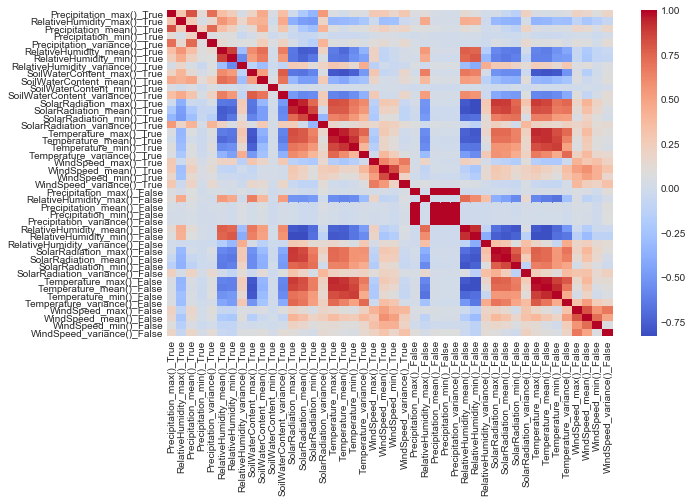

region: SA
                                     rmse        min           max
Precipitation_max()             76.388249   0.000000  3.339711e+03
RelativeHumidity_max()           8.641060  53.073027  9.941658e+01
SolarRadiation_max()             3.991305   9.144762  4.384800e+01
Temperature_max()                2.956829  11.846393  4.256830e+01
WindSpeed_max()                  2.146383   3.968629  1.859526e+01
Precipitation_mean()            14.965235   0.000000  6.588669e+02
RelativeHumidity_mean()         11.465598  15.208807  8.491407e+01
SolarRadiation_mean()            4.241249   4.354190  4.104075e+01
Temperature_mean()               2.937494   7.715289  3.813063e+01
WindSpeed_mean()                 1.287955   1.819643  1.059062e+01
Precipitation_min()              1.899956   0.000000  8.364115e+01
RelativeHumidity_min()           7.550024   5.048053  6.849792e+01
SolarRadiation_min()             4.665018   1.143423  3.326103e+01
Temperature_min()                2.097701   1.92883

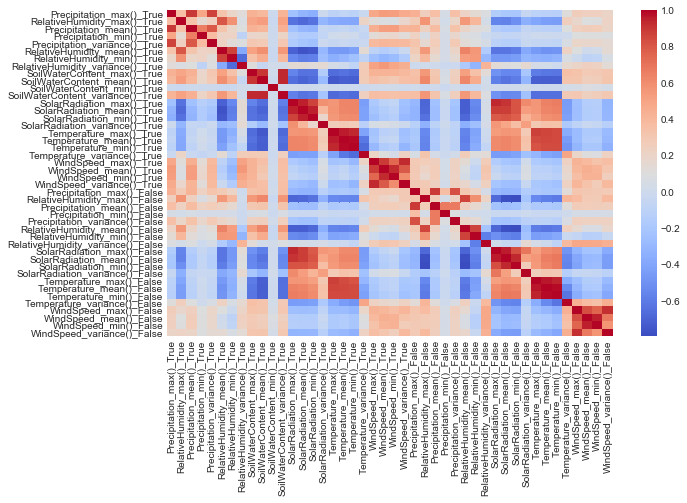

region: TA
                                  rmse           min         max
Precipitation_max()          11.417198  9.536743e-04  124.443565
RelativeHumidity_max()        4.685631  6.974597e+01   99.602058
SolarRadiation_max()          3.794427  4.130881e+00   40.446621
Temperature_max()             1.675097  7.928650e+00   29.530220
WindSpeed_max()               2.627901  3.455640e+00   18.175507
Precipitation_mean()          4.584743  3.663633e-05   84.826844
RelativeHumidity_mean()       5.279429  4.612125e+01   95.061368
SolarRadiation_mean()         4.039915  1.443166e+00   38.015858
Temperature_mean()            2.057080  2.745346e+00   24.600806
WindSpeed_mean()              1.367768  1.274583e+00    9.054204
Precipitation_min()           2.039269  0.000000e+00   83.308334
RelativeHumidity_min()        6.994977  2.977427e+01   89.854851
SolarRadiation_min()          4.199383  4.826271e-01   32.709446
Temperature_min()             2.422145 -3.246695e+00   20.023191
WindSpeed_min(

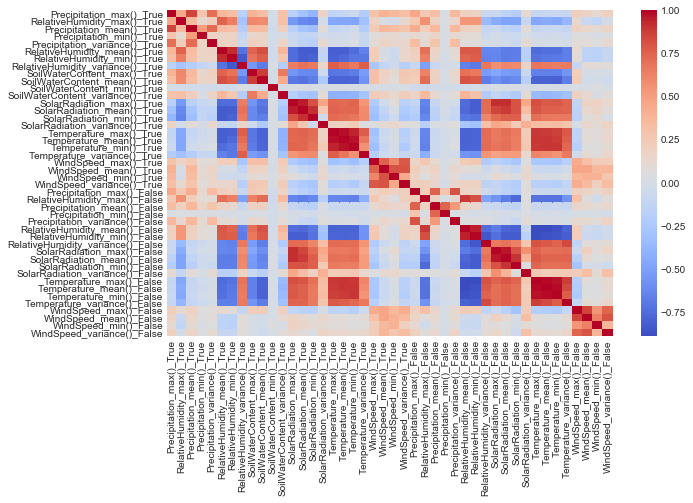

region: VI
                                  rmse        min          max
Precipitation_max()          11.091939   0.000000   124.517502
RelativeHumidity_max()        6.730475  62.750603    99.944527
SolarRadiation_max()          4.210061   5.505955    43.381081
Temperature_max()             3.094529   9.353139    39.131512
WindSpeed_max()               3.290252   3.014127    17.628710
Precipitation_mean()          3.279912   0.000000    85.316689
RelativeHumidity_mean()       9.196724  24.284964    94.451952
SolarRadiation_mean()         4.478269   2.256452    41.020994
Temperature_mean()            2.539162   4.116332    32.012934
WindSpeed_mean()              1.062027   1.291636     7.807912
Precipitation_min()           1.930578   0.000000    83.504298
RelativeHumidity_min()       11.849108   8.445331    87.338005
SolarRadiation_min()          4.606977   0.749900    37.183012
Temperature_min()             2.398361  -2.485369    22.657827
WindSpeed_min()               0.655089   0.2

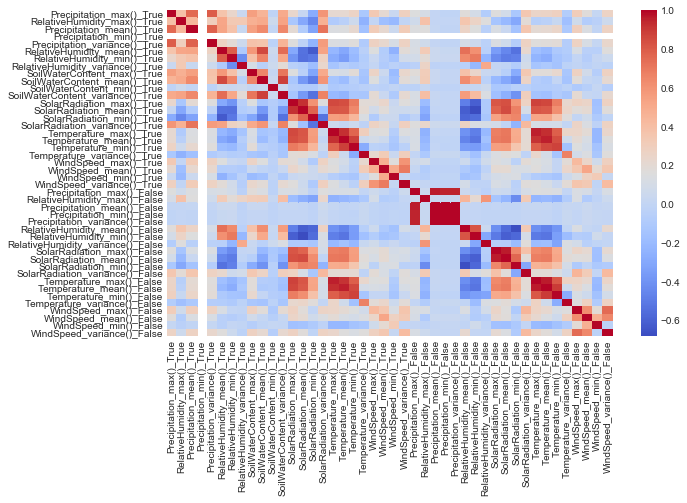

region: WA
                                      rmse        min           max
Precipitation_max()              81.977876   0.000000  3.345263e+03
RelativeHumidity_max()            6.235454  63.784002  9.922295e+01
SolarRadiation_max()              3.996091  17.040407  4.190400e+01
Temperature_max()                 1.823282  22.780846  4.219955e+01
WindSpeed_max()                   1.889199   4.756890  2.071867e+01
Precipitation_mean()             28.420578   0.000000  1.250321e+03
RelativeHumidity_mean()           8.853805  16.943452  8.145935e+01
SolarRadiation_mean()             3.558358   7.903442  3.791802e+01
Temperature_mean()                1.999424  11.390000  3.469650e+01
WindSpeed_mean()                  1.148564   2.190281  8.593019e+00
Precipitation_min()               1.909620   0.000000  8.406667e+01
RelativeHumidity_min()            4.735628   4.247879  4.836736e+01
SolarRadiation_min()              4.383683   0.471058  2.777499e+01
Temperature_min()                 1.8

In [46]:
def hello_region(ori):
    df = ori.copy()
    regions = np.unique(df['Region'])
   
    for r in regions:
        weat, features = format_weather(weather, region = r)
        fore, _ = format_weather(forecast, region = r, actual = False)

        weat = weat.set_index('Date')
        fore = fore.set_index('Date')
        df = weat.join(fore).dropna()

        plt.figure(figsize = (10, 6))
        sns.heatmap(df.corr(), cmap = "coolwarm", xticklabels = True, yticklabels = True)
        plt.show()
        
        features = features[1:]

        error = {}
        for feature in features:
            if feature + '_True' not in df:
                continue
            if feature + '_False' not in df:
                continue
            error[feature] = [
                np.sqrt(mean_squared_error(df[feature + '_True'], df[feature + '_False'])),
                min(min(df[feature + '_True']), min(df[feature + '_False'])),
                max(max(df[feature + '_True']), max(df[feature + '_False'])),
            ]

        rmse = pd.DataFrame.from_dict(error, orient = 'index', columns = ['rmse', 'min', 'max'])
        print(f"region: {r}")
        print(rmse)

hello_region(weather)

In [47]:
hello = forecast.set_index('Date')
hello5 = hello[(hello['Lead time'] == 5) & (hello['Region'] == 'NSW')]

df, _ = format_weather(hello5)
df

,Date,Precipitation_max()_True,RelativeHumidity_max()_True,Precipitation_mean()_True,Precipitation_min()_True,Precipitation_variance()_True,RelativeHumidity_mean()_True,RelativeHumidity_min()_True,RelativeHumidity_variance()_True,SolarRadiation_max()_True,...,SolarRadiation_min()_True,SolarRadiation_variance()_True,Temperature_max()_True,Temperature_mean()_True,Temperature_min()_True,Temperature_variance()_True,WindSpeed_max()_True,WindSpeed_mean()_True,WindSpeed_min()_True,WindSpeed_variance()_True
0,2014-01-01,NaN,85.021118,NaN,NaN,NaN,28.223569,7.482927,353.620815,33.557598,...,24.865765,2.276068,36.929035,30.893523,21.243755,17.918553,6.989559,3.958822,1.593531,1.334834
1,2014-01-02,NaN,88.326843,NaN,NaN,NaN,41.854657,21.636490,176.478199,32.559563,...,10.489035,22.812302,37.110737,30.945624,21.260912,17.396995,10.682782,5.116995,1.434490,5.253837
2,2014-01-03,NaN,85.432808,NaN,NaN,NaN,40.073863,23.991610,170.653427,32.385204,...,11.779593,22.217494,36.304554,28.740031,15.639575,16.553366,10.795617,5.696997,1.511390,6.354403
3,2014-01-04,NaN,79.544380,NaN,NaN,NaN,40.334391,20.122776,244.922272,34.926014,...,20.678528,4.588158,32.729553,23.613320,11.868508,13.024237,8.223342,4.260682,1.277267,1.689959
4,2014-01-05,NaN,90.869308,NaN,NaN,NaN,39.400439,15.113902,317.980265,35.354248,...,8.228070,18.756798,29.856218,22.985766,12.450391,10.446423,7.229513,3.967104,1.000668,2.615668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2020-10-27,20.658161,97.458572,1.619099,0.0,5.257412,62.803447,20.048918,352.025810,30.812401,...,5.894617,23.021273,23.648430,17.484295,5.738750,12.083607,7.642264,3.799964,0.506275,1.533891
2470,2020-10-28,29.182055,96.433640,5.882079,0.0,43.487377,64.745909,32.563313,347.448510,30.352476,...,10.064366,19.727505,22.224161,16.775319,7.380421,10.723898,6.493535,3.616319,0.593930,2.367506
2471,2020-10-29,17.034100,98.126480,2.182718,0.0,13.860925,62.670761,25.979952,357.422578,29.758884,...,2.634050,19.411917,22.166502,16.935631,5.767390,11.743674,6.213646,3.419582,0.709092,1.317666
2472,2020-10-30,35.691467,95.562111,6.338376,0.0,67.886770,59.628419,27.630579,259.036976,30.527601,...,10.692318,10.996966,25.733540,18.860621,8.536010,11.304182,12.004852,4.763255,0.474671,7.753052


In [48]:
df.shift(periods = 1).dropna()

,Date,Precipitation_max()_True,RelativeHumidity_max()_True,Precipitation_mean()_True,Precipitation_min()_True,Precipitation_variance()_True,RelativeHumidity_mean()_True,RelativeHumidity_min()_True,RelativeHumidity_variance()_True,SolarRadiation_max()_True,...,SolarRadiation_min()_True,SolarRadiation_variance()_True,Temperature_max()_True,Temperature_mean()_True,Temperature_min()_True,Temperature_variance()_True,WindSpeed_max()_True,WindSpeed_mean()_True,WindSpeed_min()_True,WindSpeed_variance()_True
531,2015-07-06,0.676588,96.380577,0.015649,0.0,0.004120,62.832873,36.506927,144.521980,14.294098,...,1.310407,7.179963,17.923838,10.280841,1.781415,5.677777,7.471239,3.541415,1.183472,1.095084
532,2015-07-07,2.361713,93.276802,0.108142,0.0,0.088243,65.316988,39.858982,108.082513,14.775929,...,3.958993,2.508597,16.054276,9.670909,0.099376,7.388896,5.145082,1.640997,0.602412,0.258214
533,2015-07-08,1.013023,85.405472,0.023666,0.0,0.008955,67.499237,45.383556,95.738926,14.922725,...,6.651114,2.167692,15.528275,8.917964,-0.059143,5.448867,5.736852,2.012812,0.603009,0.463311
534,2015-07-09,36.588108,98.264542,1.925606,0.0,17.834090,66.793794,46.847240,224.322595,14.840615,...,1.350860,10.691887,15.895335,10.853388,4.177390,3.343773,7.940071,2.542946,0.531210,0.936067
535,2015-07-10,21.286840,98.774033,3.184264,0.0,20.252060,78.345405,46.337391,278.517736,13.248702,...,1.358067,11.847141,17.526588,11.332001,2.698585,5.363875,6.820446,3.373875,0.830497,1.447548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2020-10-26,24.708494,98.824936,3.050198,0.0,18.905541,64.635384,21.440392,590.658684,30.796028,...,2.041849,84.573622,22.703629,16.140003,3.288619,14.092621,8.630863,3.678312,0.484330,2.557126
2470,2020-10-27,20.658161,97.458572,1.619099,0.0,5.257412,62.803447,20.048918,352.025810,30.812401,...,5.894617,23.021273,23.648430,17.484295,5.738750,12.083607,7.642264,3.799964,0.506275,1.533891
2471,2020-10-28,29.182055,96.433640,5.882079,0.0,43.487377,64.745909,32.563313,347.448510,30.352476,...,10.064366,19.727505,22.224161,16.775319,7.380421,10.723898,6.493535,3.616319,0.593930,2.367506
2472,2020-10-29,17.034100,98.126480,2.182718,0.0,13.860925,62.670761,25.979952,357.422578,29.758884,...,2.634050,19.411917,22.166502,16.935631,5.767390,11.743674,6.213646,3.419582,0.709092,1.317666


In [49]:
hello5

,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
Date,,,,,,,,
2014-01-01,NSW,RelativeHumidity,5,803768.19762,7.482927,85.021118,28.223569,353.620815
2014-01-01,NSW,SolarRadiation,5,803768.19762,24.865765,33.557598,31.647308,2.276068
2014-01-01,NSW,Temperature,5,803768.19762,21.243755,36.929035,30.893523,17.918553
2014-01-01,NSW,WindSpeed,5,803768.19762,1.593531,6.989559,3.958822,1.334834
2014-01-02,NSW,RelativeHumidity,5,803768.19762,21.636490,88.326843,41.854657,176.478199
...,...,...,...,...,...,...,...,...
2020-10-31,NSW,Precipitation,5,803768.19762,0.000000,99.787331,4.827424,111.576089
2020-10-31,NSW,RelativeHumidity,5,803768.19762,36.675171,95.294411,62.687009,190.936393
2020-10-31,NSW,SolarRadiation,5,803768.19762,8.198900,30.828644,24.316985,21.342507
